# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pipes
import random
import re
import tempfile
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DISTANCE = "distance"
FACEMASK = "mondkapje"
TOPIC = DISTANCE # <====================================
#TOPIC = FACEMASK

DATADIR = "../data/"
if TOPIC == FACEMASK: FILETWEETS = TOPIC+"-tweets+nunl.csv"
else: FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
SOURCE = "source"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")
mainAnnotator = annotations.iloc[0][0]

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    if annotator == mainAnnotator and tweetId in list(tweets.index):
        tweetUser = tweets.loc[tweetId][1]
        tweetLabel = annotations.iloc[i][4]
        if tweetLabel == NEUTRAL: tweetLabel = IRRELEVANT
        if tweetLabel == ANDERS: tweetLabel = IRRELEVANT
        if tweetLabel == EENS: tweetLabel = SUPPORTS
        if tweetLabel == ONEENS: tweetLabel = REJECTS
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:preprocess(tweets.loc[tweetId][TEXT])}

In [6]:
len(fasttextData),len(tweets),len(annotations)

(5977, 6835, 7286)

In [7]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [8]:
annotations1 = annotations[annotations[0]==mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations1[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations1[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.3 ; 1000 tweets take: 189 minutes


In [9]:
annotations2 = annotations[annotations[0]!=mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations2[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations2[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 3.6 ; 1000 tweets take: 278 minutes


In [10]:
tmp_labels = {}
for data in fasttextData:
    label = fasttextData[data]["label"]
    if label not in tmp_labels:
        tmp_labels[label] = 0
    tmp_labels[label] += 1
guess_score = 0
for label in tmp_labels:
    print(f"{100*tmp_labels[label]/len(fasttextData)} {label}")
    guess_score += tmp_labels[label]/len(fasttextData) * tmp_labels[label]/len(fasttextData)
guess_score

19.95984607662707 __label__REJECTS
56.232223523506775 __label__SUPPORTS
23.807930399866155 __label__IRRELEVANT


0.41272759677251447

| label | percentage |
| ---------- | ------- |
| REJECT     | 20.0% |
| SUPPORTS   | 56.2% |
| IRRELEVANT | 23.8% |

## Fasttext run and evaluation

In [11]:
import fasttext
import random
from IPython.display import clear_output

In [12]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [13]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [14]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

5731

In [15]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [16]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [17]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        validationStart = round(fold*len(fasttextData)/n)
        validationEnd = round((fold+1)*len(fasttextData)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        testStart = round(nextFold*len(fasttextData)/n)
        testEnd = round((nextFold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i >= testStart and i < testEnd: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart and i < validationEnd: 
                print(data,file=validationFile)
                validationData.append(data)
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors="twiqs-model-2020.vec")
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData))
        print(fold, end=" ")
        evaluate(predictionCountsTest, predictionLabelsTest, fasttextData[testStart:testEnd])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
        pd.DataFrame(predictionCountsValidation).to_csv("csv/predictionCountsValidation.csv")
        pd.DataFrame(predictionCountsTest).to_csv("csv/predictionCountsTest.csv")
        pd.DataFrame(predictionLabelsValidation).to_csv("csv/predictionLabelsValidation.csv")
        pd.DataFrame(predictionLabelsTest).to_csv("csv/predictionLabelsTest.csv")
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [18]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [19]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
    numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
    numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
    numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
    fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

## Grid search (skip)

In [ ]:
scoresValidation = {}
scoresTest = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200]:
        for lr in [0.05,0.1,0.2]:
            predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
                runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            key = ",".join([str(dim),str(epoch),str(lr)])
            print(f"{dim:3} {epoch:3} {lr:0.2f}",end=" validation: ")
            scoresValidation[key] = evaluate(predictionCountsValidation,predictionLabelsValidation,fasttextData)
            print(f"{dim:3} {epoch:3} {lr:0.2f}",end="       test: ")
            scoresTest[key] = evaluate(predictionCountsTest,predictionLabelsTest,fasttextData)

In [ ]:
print("optimizing accuracy via validation data")
[(scoresValidation[k],k) for k in sorted(scoresValidation.keys(),\
                                         key=lambda k:scoresValidation[k][0],reverse=True)][0:10]

In [ ]:
print("checking best accuracy for test data")
[(scoresTest[k],k) for k in sorted(scoresTest.keys(),\
                                         key=lambda k:scoresTest[k][0],reverse=True)][0:10]

Facemasks: best validation accuracy 0.56 for '20,50,0.1', associated test accuracy 0.56 (5th score).

Social distancing: best validation accuracy 0.65 for '300,10,0.2', associated test accuracy 0.65 (top score).

In [ ]:
print("optimizing fraction via validation data")
[(scoresValidation[k],k) for k in sorted(scoresValidation.keys(),
                                         key=lambda k:scoresValidation[k][1],reverse=True)][0:10]

In [ ]:
print("checking fraction for test data")
[(scoresTest[k],k) for k in sorted(scoresTest.keys(),
                                         key=lambda k:scoresTest[k][1],reverse=True)][0:10]

Facemasks: best validation ratio: 1.48 for '10,200,0.2'; associated test ratio: 1.70 (8th scsore)

Social distancing: best validation ratio 0.88 for '200,200,0.2'; associated test accuracy 0.83 (top score).

## Check relation accuracy and fraction (skip)

In [ ]:
THRESHOLD = 0.62

plt.figure(figsize=(6,3))
ax1 = plt.subplot(121)
x1 = [scoresTest[key][0] for key in scoresValidation]
y1 = [scoresTest[key][1] for key in scoresValidation]
ax1.scatter(x1,y1)
ax2 = plt.subplot(122)
x2 = [scoresTest[key][0] for key in scoresValidation if scoresTest[key][0] > THRESHOLD]
y2 = [scoresTest[key][1] for key in scoresValidation if scoresTest[key][0] > THRESHOLD]
ax2.scatter(x2,y2)
plt.xlabel("fraction")
plt.ylabel("accuracy")
plt.show()

In [ ]:
np.corrcoef(x1,y1)[0][1],np.corrcoef(x2,y2)[0][1]

In [ ]:
N = 5
scoresN = {} 
triplets = [(20,300,0.2),(50,200,0.2),(300,200,0.2),(20,200,0.05),(10,300,0.2)]

for triplet in triplets:
    dim,epoch,lr = triplet
    key = " ".join([str(dim),str(epoch),str(lr)])
    scoresN[key] = []
    for i in range(0,N): 
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
        print(dim,epoch,lr,end=" ")
        scoresN[key].append(evaluate(predictionCounts,predictionLabels,fasttextData))

In [ ]:
scoresNaverage = {}
for key in scoresN: scoresNaverage[key] = round(np.average([x[1] for x in scoresN[key]]),3)
{key:scoresNaverage[key] for key in sorted(scoresNaverage.keys(),key=lambda k:scoresNaverage[k],reverse=True)}

In [ ]:
for dim in [10]:
    for epoch in [900]:
        for lr in [0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = ",".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

## Run with best parameters (skip, except for first block)

In [20]:
def setBestParameters():
    if TOPIC == DISTANCE:
        # social distancing (202008: 20,300,0.9) (202009a:20,10,0.05) (202009b:10,10,0.2) (202010:200,200,0.2) (emnlp:10,10,0.2)
        BESTDIM = 300 # 20210304: was 200
        BESTEPOCH = 200
        BESTLR = 0.2
    elif TOPIC == FACEMASK:
        # facemasks (202008: 10,900,0.2) (202010:10,200,0.2) (emnlp:300,10,0.2)
        BESTDIM = 300 # from emnlp
        BESTEPOCH = 10
        BESTLR = 0.2
    else:
        print("unknown topic!",file=sys.stderr)
        sys.exit(1)
    return(BESTDIM,BESTEPOCH,BESTLR)
        
BESTDIM,BESTEPOCH,BESTLR = setBestParameters()

The next block takes a lot of time to run so it is best to skip it

In [21]:
run_fasttext = True
if run_fasttext:
    predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
        runFasttext(fasttextData, dim=BESTDIM, epoch=BESTEPOCH, lr=BESTLR, squealFlag=False)

Read 0M words
Number of words:  17915
Number of labels: 3
Progress: 100.0% words/sec/thread: 2039159 lr:  0.000000 avg.loss:  0.002489 ETA:   0h 0m 0s 1m59s 0.088623 avg.loss:  0.003195 ETA:   0h 0m58s


0 cases: 573; precision: 0.756; recall: 0.756; fraction: 1.123


Read 0M words
Number of words:  17712
Number of labels: 3
Progress: 100.0% words/sec/thread: 2055572 lr:  0.000000 avg.loss:  0.002568 ETA:   0h 0m 0s


1 cases: 1146; precision: 0.661; recall: 0.661; fraction: 0.403


Read 0M words
Number of words:  17526
Number of labels: 3
Progress: 100.0% words/sec/thread: 2074151 lr:  0.000000 avg.loss:  0.002276 ETA:   0h 0m 0s 56.8% words/sec/thread: 2076123 lr:  0.086492 avg.loss:  0.002951 ETA:   0h 0m55s


2 cases: 1719; precision: 0.657; recall: 0.657; fraction: 0.643


Read 0M words
Number of words:  17711
Number of labels: 3
Progress: 100.0% words/sec/thread: 2066142 lr:  0.000000 avg.loss:  0.002257 ETA:   0h 0m 0s 0.002762 ETA:   0h 0m45s


3 cases: 2293; precision: 0.646; recall: 0.646; fraction: 0.573


Read 0M words
Number of words:  17796
Number of labels: 3
Progress: 100.0% words/sec/thread: 2067199 lr:  0.000000 avg.loss:  0.002253 ETA:   0h 0m 0s


4 cases: 2866; precision: 0.648; recall: 0.648; fraction: 0.356


Read 0M words
Number of words:  17704
Number of labels: 3
Progress: 100.0% words/sec/thread: 2048936 lr:  0.000000 avg.loss:  0.002711 ETA:   0h 0m 0s


5 cases: 3439; precision: 0.648; recall: 0.648; fraction: 0.384


Read 0M words
Number of words:  17881
Number of labels: 3
Progress: 100.0% words/sec/thread: 2063991 lr:  0.000000 avg.loss:  0.002440 ETA:   0h 0m 0s


6 cases: 4012; precision: 0.653; recall: 0.653; fraction: 0.444


Read 0M words
Number of words:  18290
Number of labels: 3
Progress: 100.0% words/sec/thread: 2060573 lr:  0.000000 avg.loss:  0.002478 ETA:   0h 0m 0s


7 cases: 4585; precision: 0.647; recall: 0.647; fraction: 0.376


Read 0M words
Number of words:  18096
Number of labels: 3
Progress: 100.0% words/sec/thread: 2061920 lr:  0.000000 avg.loss:  0.002491 ETA:   0h 0m 0s 0.003638 avg.loss:  0.002510 ETA:   0h 0m 2s


8 cases: 5158; precision: 0.647; recall: 0.647; fraction: 0.388


Read 0M words
Number of words:  17811
Number of labels: 3
Progress: 100.0% words/sec/thread: 2052718 lr:  0.000000 avg.loss:  0.002540 ETA:   0h 0m 0s


9 cases: 5731; precision: 0.649; recall: 0.649; fraction: 0.852


In [22]:
if not run_fasttext:
    predictionCountsValidation = pd.read_csv("csv/predictionCountsValidation.csv")
    predictionCountsTest = pd.read_csv("csv/predictionCountsTest.csv")
    predictionLabelsValidation = pd.read_csv("csv/predictionLabelsValidation.csv")
    predictionLabelsTest = pd.read_csv("csv/predictionLabelsTest.csv")

In [24]:
evaluate(predictionCountsValidation,predictionLabelsValidation,fasttextData)
evaluate(predictionCountsTest,predictionLabelsTest,fasttextData)

cases: 5731; precision: 0.653; recall: 0.653; fraction: 0.911
cases: 5731; precision: 0.649; recall: 0.649; fraction: 0.846


(0.649, 0.8461392814824769)

In [25]:
gold = []
for text in fasttextData:
    gold.append(re.sub(" .*", "", text))

In [47]:
predicted = []
for fold in range(0, len(predictionLabelsValidation)):
    for label in predictionLabelsValidation[fold][0]:
        predicted.append(label[0])

In [27]:
#predicted = []
#for fold in range(0, len(predictionLabelsTest)):
#    for label in predictionLabelsTest[fold-1][0]:
#        predicted.append(label[0])

In [48]:
from sklearn import metrics

metrics.confusion_matrix(gold, predicted, labels=['__label__IRRELEVANT', '__label__REJECTS', '__label__SUPPORTS'])

array([[ 564,  212,  591],
       [ 202,  637,  297],
       [ 434,  251, 2543]])

In [49]:
print((564+637+2543)/(564+212+591+202+637+297+434+251+2543))

0.6532891292968068


In [51]:
print((212+591+202+434)/(564+212+591+202+637+297+434+251+2543))

0.25109056011167336


In [52]:
print((297+251)/(564+212+591+202+637+297+434+251+2543))

0.0956203105915198


In [39]:
print((568+601+2549)/(568+205+594+219+601+316+455+224+2549))

0.6487523992322457


In [53]:
print((202+637+297)/(434+251+2543), (212+637+251)/(591+297+2543))

0.35192069392812886 0.3206062372486156


In [28]:
correct = {}
wrong = {}
missed = {}
for i in range(0, len(predicted)):
    if predicted[i] == gold[i]:
        if gold[i] not in correct:
            correct[gold[i]] = 0
        correct[gold[i]] += 1
    else:
        if gold[i] not in missed:
            missed[gold[i]] = 0
        missed[gold[i]] += 1
        if predicted[i] not in wrong:
            wrong[predicted[i]] = 0
        wrong[predicted[i]] += 1

In [29]:
print("Preci Recal Label")
for label in sorted(set(list(missed.keys()) + list(wrong.keys()) + list(correct.keys()))):
    if label not in correct:
        correct[label] = 0
    if label not in missed:
        missed[label] = 0
    if label not in wrong:
        wrong[label] = 0
    print(f"{100*correct[label]/(correct[label]+wrong[label]):0.1f}% {100*correct[label]/(correct[label]+missed[label]):0.1f}%", end=" ")
    print(re.sub("__label__", "", label))

Preci Recal Label
45.7% 41.6% IRRELEVANT
58.3% 52.9% REJECTS
73.7% 79.0% SUPPORTS


| Precision | Recall | Label | dataset    |
| --------- | ------ | ------| ---------- |
| 46.6% | 40.8% | IRRELEVANT | validation |
| 57.5% | 55.7% | REJECTS    | validation |
| 73.9% | 78.7% | SUPPORTS   | validation |
| 45.5% | 41.0% | IRRELEVANT | test       |
| 58.5% | 52.9% | REJECTS    | test       |
| 73.5% | 79.1% | SUPPORTS   | test       |

In [ ]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttextData, dim=BESTDIM, epoch=BESTEPOCH, lr=BESTLR, squealFlag=False)

In [ ]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

In [ ]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

In [ ]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabelsTest)):
    for label in predictionLabelsTest[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

In [ ]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

In [ ]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

In [ ]:
makeConfusionMatrix(fasttextData,predictionLabelsTest)

For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [ ]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [ ]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

## Relation training data size - accuracy (skip)

In [ ]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000,10000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
            runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCountsTest,predictionLabelsTest,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

In [ ]:
del(expResultsAll[list(expResultsAll.keys())[-1]])

In [ ]:
PLOTFILENAME = "training-size.png"

plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("training data size")
plt.title("Accuracy related to training size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("fraction")
plt.xlabel("training data size")
plt.title("Fraction score related to training size")
plt.savefig(PLOTFILENAME)
plt.show()

## Classifying unlabeled tweets

In [20]:
import fasttext
import matplotlib
import numpy as np
import os
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer

In [21]:
BESTDIM,BESTEPOCH,BESTLR = setBestParameters()

In [22]:
BASEDIR = "/home/erikt/projects/puregome/data/"
DATADIRECTORY = BASEDIR+"text/"
DATADIRECTORYREDDIT = BASEDIR+"reddit/text/"
DATADIRECTORYNUNL = BASEDIR+"nunl/text/"
TWITTER = "twitter"
REDDIT = "reddit"
NUNL = "nunl"
SOURCES = [TWITTER,REDDIT,NUNL]
DATADIRECTORIES = {TWITTER:DATADIRECTORY,REDDIT:DATADIRECTORYREDDIT,NUNL:DATADIRECTORYNUNL}
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
TEXT = "text"
USER = "user"
TOTAL = "total"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [23]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [24]:
SCREENNAME = "screenname"

def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query,dataDirectory=DATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                matchedText = fileData[fileData[TEXT].str.contains(query,case=False)]
                matchedTextPreprocessed = matchedText[TEXT].apply(lambda x:preprocess(x))
                testData.extend(list(matchedTextPreprocessed))
            except:
                pass
    return(testData)

def readDataGeo(datePattern,query,dataDirectory=DATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = []
    locations = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                matchedText = fileData[fileData[TEXT].str.contains(query,case=False)]
                matchedTextPreprocessed = matchedText[TEXT].apply(lambda x:preprocess(x))
                testData.extend(matchedTextPreprocessed)
            except:
                pass
    return(testData)

def classify(datePattern,query,model,dataDirectory=DATADIRECTORY):
    testData = readData(datePattern,query,dataDirectory)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    labelPercentages[TOTAL] = nbrOfLabels
    return(labelPercentages)

In [4]:
import ast


RESULTSFILE = "results-"+TOPIC+".csv"


def storeResults(results, results_file=RESULTSFILE):
     pd.DataFrame(results).T.to_csv(results_file, index_label=SOURCE)

        
def readResults(results_file=RESULTSFILE):
    try:
        df = pd.read_csv(results_file, index_col=SOURCE)
        for source in df.index:
            for date in df.loc[source].index:
                try:
                    df.loc[source][date] = ast.literal_eval(df.loc[source][date])
                except: pass
        return(removeNan(df.T.to_dict()))
    except:
        return({})


def combineResults(results_target, results_source):
    for source in results_source:
        if not source in results_target:
            results_target[source] = {}
        for date in results_source[source]:
            if date in results_target[source]:
                print(f"duplicate date: {date}!")
            else:
                results_target[source][date] = results_source[source][date]

            
def getTotals(results):
    totals = {}
    for source in results:
        for date in results[source]:
            try:
                if not source in totals: totals[source] = 0
                totals[source] += results[source][date][TOTAL]
            except: pass
    return(totals)


def removeNan(results):
    for source in results:
        toBeDeleted = []
        for date in results[source]:
            if results[source][date] != results[source][date]:
                toBeDeleted.append(date)
        for date in toBeDeleted: del(results[source][date])
    return(results)

In [26]:
#results2021 = readResults()
#results2020 = readResults(results_file=RESULTSFILE + ".20201231")
#results = {}
#combineResults(results, results2020)
#combineResults(results, results2021)
#totals =  getTotals(results)

In [27]:
MAXDAYSPERMONTH = 31
MODELFILE = f"model-{TOPIC}-{BESTDIM}-{BESTEPOCH}-{BESTLR}.bin"

if TOPIC == DISTANCE:
    QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
elif TOPIC == FACEMASK:
    QUERY = TOPIC
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)
MAXDAYSPERMONTH = 31

model = fasttext.train_supervised(FILEFASTTEXT, dim=BESTDIM, epoch=BESTEPOCH, lr=BESTLR) #, pretrainedVectors="twiqs-model-2020.vec")
model.save_model(MODELFILE)

Read 0M words
Number of words:  6489
Number of labels: 3
Progress: 100.0% words/sec/thread: 2274079 lr:  0.000000 avg.loss:  0.941615 ETA:   0h 0m 0s


In [28]:
model = fasttext.load_model(MODELFILE)

### Recompute results per data source (run once per month)

In [29]:
results = {}
totals = {}
for source in SOURCES:
    dataDirectory = DATADIRECTORIES[source]
    total = 0
    results[source] = {}
    for month in "202104 202105 202106 202107 202108 202109 202110 202111 202112 202201 202202 202203 202204".split():
        for day in range(1,MAXDAYSPERMONTH+1):
            date = month+str(day).zfill(2)
            try:
                labels = classify(date,QUERY,model,dataDirectory=dataDirectory)
                if not REJECTS in labels: labels[REJECTS] = 0
                if not SUPPORTS in labels: labels[SUPPORTS] = 0
                if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
                if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                    results[source][date] = labels
                    print(source,date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT],labels[TOTAL])
                    total += labels[TOTAL]
            except:
                print(source,date,"error")
    totals[source] = total
    print("total relevant found:",total)

twitter 20210401 82.3 17.7 134.4 1004
twitter 20210402 77.9 22.1 99.6 970
twitter 20210403 78.6 21.4 127.7 939
twitter 20210404 68.8 31.2 188.7 679
twitter 20210405 89.0 11.0 244.4 656
twitter 20210406 89.0 11.0 142.8 919
twitter 20210407 92.2 7.8 118.3 1135
twitter 20210408 94.4 5.6 149.6 1400
twitter 20210409 87.2 12.8 185.6 876
twitter 20210410 87.0 13.0 156.4 801
twitter 20210411 85.0 15.0 190.0 880
twitter 20210412 85.6 14.4 185.3 1044
twitter 20210413 91.0 9.0 160.8 955
twitter 20210414 94.5 5.5 252.3 577
twitter 20210415 91.5 8.5 216.2 493
twitter 20210416 91.8 8.2 132.7 971
twitter 20210417 80.4 19.6 189.8 738
twitter 20210418 93.1 6.9 161.7 866
twitter 20210419 92.5 7.5 184.9 967
twitter 20210420 84.9 15.1 212.9 852
twitter 20210421 90.1 9.9 108.4 1397
twitter 20210422 95.7 4.3 101.1 1839
twitter 20210423 81.9 18.1 191.3 1018
twitter 20210424 89.2 10.8 161.6 1025
twitter 20210425 93.8 6.2 113.6 1072
twitter 20210426 93.1 6.9 93.3 821
twitter 20210427 93.0 7.0 115.8 919
twitter

In [30]:
storeResults(results)

In [10]:
def combine_data(data1, data2):
    for platform in data2:
        if platform not in data1:
            data1[platform] = {}
        for date in data2[platform]:
            data1[platform][date] = data2[platform][date]
    return data1

In [14]:
for topic in ["distance", "mondkapje"]:
    data1 = readResults(results_file=f"results-{topic}.csv.20210406")
    data2 = readResults(results_file=f"results-{topic}.csv.20220513")
    storeResults(combine_data(data1, data2), results_file=f"results-{topic}.csv")

## Continue here...

In [31]:
totals

{'twitter': 481002, 'reddit': 1420, 'nunl': 4079}

In [32]:
for platform in "twitter reddit nunl".split():
    counts = {}
    for date in results[platform]:
        try:
            if TOTAL in results[platform][date] and results[platform][date][TOTAL] > 0:
                for label in results[platform][date].keys():
                    if not label in counts: counts[label] = 0
                    if label == TOTAL: counts[label] += results[platform][date][label]
                    else: counts[label] += round(results[platform][date][TOTAL]*results[platform][date][label]/100.0)
        except: pass
    print(platform,counts)

twitter {'__label__IRRELEVANT': 762248, '__label__REJECTS': 431639, '__label__SUPPORTS': 49363, 'total': 481002}
reddit {'__label__IRRELEVANT': 1112, '__label__REJECTS': 1244, '__label__SUPPORTS': 176, 'total': 1420}
nunl {'__label__IRRELEVANT': 2717, '__label__REJECTS': 3420, '__label__SUPPORTS': 659, 'total': 4079}


Social distancing:
```
twitter {'__label__IRRELEVANT': 321240, '__label__REJECTS': 292168, '__label__SUPPORTS': 707633, 'total': 999800}
reddit {'__label__SUPPORTS': 2967, 'total': 3857, '__label__REJECTS': 890, '__label__IRRELEVANT': 411}
nunl {'__label__IRRELEVANT': 7760, '__label__SUPPORTS': 39671, 'total': 53243, '__label__REJECTS': 13572}
```
Face masks:
```
twitter {'__label__IRRELEVANT': 821039, '__label__REJECTS': 791113, 'total': 910603, '__label__SUPPORTS': 119490}
reddit {'__label__IRRELEVANT': 2368, '__label__REJECTS': 1697, '__label__SUPPORTS': 496, 'total': 2193}
nunl {'__label__IRRELEVANT': 27926, '__label__REJECTS': 32008, '__label__SUPPORTS': 11438, 'total': 43446}
```

In [33]:
df = pd.read_csv(RESULTSFILE,index_col="source").T
totalsIncludingIrrelevant = {source:0 for source in [TWITTER,REDDIT,NUNL]}
for i in range(0,len(df)):
    for source in [TWITTER,REDDIT,NUNL]:
        try:
            dictionary = ast.literal_eval(df.iloc[i][source])
        except:
            dictionary = {TOTAL:0}
        if dictionary[TOTAL] > 0:
            totalsIncludingIrrelevant[source] += round((1+dictionary[IRRELEVANT]/100)*dictionary[TOTAL])
totalsIncludingIrrelevant

FileNotFoundError: [Errno 2] No such file or directory: 'results-mondkapje.csv'

## Visualization over time

In [34]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [35]:
def movingAverage(numberList,size):
    newList = []
    start_offset = int(size/2)
    for i in range(0,len(numberList)):
        newList.append(numberList[i])
        numbersUsed = 1
        for j in range(-start_offset,size-start_offset):
            if i+j >= 0 and i+j < len(numberList) and i+j != i:
                newList[i] += numberList[i+j]
                numbersUsed += 1
        newList[i] /= numbersUsed
    return(newList)

In [36]:
def pretty_number(number):
    digits = str(number)
    pretty_digits = ""
    for i in range(0,len(digits)):
        if i > 0 and i % 3 == 0: pretty_digits = ","+pretty_digits
        pretty_digits = digits[-1-i]+pretty_digits
    return(pretty_digits)

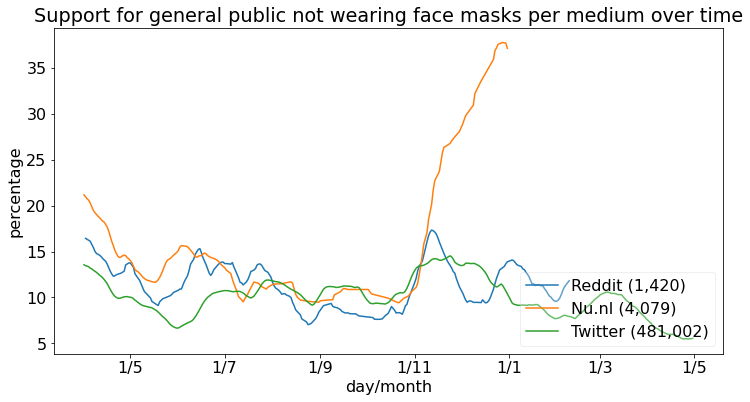

In [41]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 30
EXTRASMOOTHDAYS = 7
STARTDATE = "20200310"
LABELS = {TWITTER: f"Twitter ({pretty_number(totals[TWITTER])})",\
          NUNL: f"Nu.nl ({pretty_number(totals[NUNL])})",\
          REDDIT: f"Reddit ({pretty_number(totals[REDDIT])})"}
if TOPIC == DISTANCE:
    PLOTFILENAME = "social-distancing-all.png"
elif TOPIC == FACEMASK:
    PLOTFILENAME = "mondkapje-all.png"
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)

x = {}
ySupports = {}
plt.subplots(figsize=(12,6))
font = {"size":16}
matplotlib.rc("font",**font)
ax = plt.subplot(111)
for source in [REDDIT,NUNL,TWITTER]:
    x[source] = [datetime.datetime.strptime(k,DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage(movingAverage([results[source][k][SUPPORTS] for k in results[source].keys()],DAYSCOMBINED),EXTRASMOOTHDAYS)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label=LABELS[source])
plt.legend(framealpha=0.3,loc="lower right")
plt.ylabel("percentage")
plt.xlabel("day/month")
if TOPIC == FACEMASK:
    plt.title("Support for general public not wearing face masks per medium over time")
elif TOPIC == DISTANCE:
    plt.title("Support for social distancing per medium over time (average over "+str(DAYSCOMBINED)+" days)")
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)    
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

## Do not run any further code

In [ ]:
ANNOTATED = "annotated"
ANNOTATEDFILE = "manual-annotation.csv"
DATE = "date"
EENS = "EENS"
ONEENS = "ONEENS"
ANDERS = "ANDERS"
TOTAL = "total"

In [ ]:
df = pd.read_csv(ANNOTATEDFILE,index_col=DATE,dtype={EENS:"float",ONEENS:"float",ANDERS:"float"})
totals = []
for i in range(0,len(df)):
    total = df.iloc[i][EENS]+df.iloc[i][ONEENS]+df.iloc[i][ANDERS]
    if df.iloc[i][EENS]+df.iloc[i][ONEENS] > 0:
        df.iloc[i][EENS] = 100*df.iloc[i][EENS]/(total-df.iloc[i][ANDERS])
        df.iloc[i][ONEENS] = 100*df.iloc[i][ONEENS]/(total-df.iloc[i][ANDERS])
        df.iloc[i][ANDERS] = 100*df.iloc[i][ANDERS]/(total-df.iloc[i][ANDERS])
    else: 
        df.iloc[i][ANDERS] = 100
    totals.append(total)
df[TOTAL] = totals
annotatedDict = df.T.to_dict(orient="dict")
annotatedDict = {d:annotatedDict[d] for d in sorted(annotatedDict.keys())}
results[ANNOTATED] = annotatedDict

In [ ]:
PLOTFILEANNOTATED = "manual-annotation.png"

x = {}
ySupports = {}
plt.subplots(figsize=(12,6))
font = {"size":12}
matplotlib.rc("font",**font)
ax = plt.subplot(111)
for source in [TWITTER]:
    x[source] = [datetime.datetime.strptime(k,DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][SUPPORTS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label="predicted")
for source in [ANNOTATED]:
    x[source] = [datetime.datetime.strptime(str(k),DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][EENS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label=ANNOTATED)
plt.title("Support for social distancing per medium over time (average over "+str(DAYSCOMBINED)+" days)")
plt.legend()
plt.savefig(PLOTFILEANNOTATED)
plt.show()

In [ ]:
annotatedValues = []
twitterValues = []

for i in range(0,len(x[TWITTER])):
    date = x[TWITTER][i]
    if date >= datetime.datetime.strptime("20200310",DATEFORMAT):
        for j in range(0,len(x[ANNOTATED])):
            if x[ANNOTATED][j] == date:
                twitterValues.append(ySupports[TWITTER][i])
                annotatedValues.append(ySupports[ANNOTATED][j])
np.corrcoef(annotatedValues,twitterValues)[1][0]

In [ ]:
PLOTFILENAME = "plot.png"

plt.figure()
plt.scatter(annotatedValues,twitterValues)
plt.ylabel("Predicted support percentages")
plt.xlabel("Annotated support percentages")
plt.title("Annotated and predicted support for social distancing")
plt.savefig(PLOTFILENAME)
plt.show()

In [ ]:
allResults = results
results = results[TWITTER]

x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

keyDates = []
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        keyDates.append(list(results.keys())[i])
        print(keyDates[-1])

In [ ]:
STARTDATE = "20200310" # keyDates[0]
ENDDATE = "20201231"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(14,7))

ax1 = plt.subplot(111)
plt.plot_date(x,ySupports,fmt="-",label="Supports")
plt.plot_date(x,yRejects,fmt="-",label="Rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="Other")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("stance on the RIVM policy on "+"social")
plt.show()

In [ ]:
PLOTFILEOUT = "social-distancing.png"
#PLOTFILEOUT = "mondkapje.png"

plt.subplots(figsize=(14,7))

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(111)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="Supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="Rejects")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("Twitter stance on the RIVM policy on social distancing (average over "+str(DAYSCOMBINED)+" days)")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701 20200801".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.savefig(PLOTFILEOUT)
plt.show()

In [ ]:
counts = {}
for text in fasttextData:
    label = text.split()[0]
    if label in counts: counts[label] += 1
    else: counts[label] = 1
for label in counts: print(round(counts[label]/len(fasttextData),3),label)

## Annotator comparison

In [ ]:
NBROFTESTDATA = 100

annotators = []
annotator_data = {}
kappa_data = [{},{}]
blocked_tweet_ids = {}
tweet_labels = {}
main_annotator = ""
for row in annotations.iterrows():
    annotator = row[1][0]
    tweet_id = row[1][2]
    tweet_label = row[1][4]
    if main_annotator == "":
        main_annotator = annotator
    if tweet_label == "NEUTRAL":
        tweet_label = "ANDERS"
    if not annotator in annotator_data: 
        annotator_data[annotator] = {}
        annotators.append(annotator)
    annotator_data[annotator][tweet_id] = tweet_label
    if len(annotator_data[annotator]) <= NBROFTESTDATA: 
        blocked_tweet_ids[tweet_id] = True
    if tweet_id not in blocked_tweet_ids:
        if tweet_id not in tweet_labels:
            tweet_labels[tweet_id] = {}
        tweet_labels[tweet_id][annotator] = tweet_label

In [ ]:
results = []

for annotator in annotator_data:
    label_count = {}
    for tweet_id in annotator_data[annotator]:
        label = annotator_data[annotator][tweet_id]
        if not label in label_count: 
            label_count[label] = 0
        label_count[label] += 1
    results.append({"total": len(annotator_data[annotator])})
    for label in sorted(label_count):
        results[-1][label] = round(label_count[label] / len(annotator_data[annotator]),3)
pd.DataFrame(results)

In [ ]:
len({id_str: tweet_labels[id_str] for id_str in tweet_labels if len(tweet_labels[id_str]) > 1 })

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_data_0 = [ tweet_labels[id_str][annotators[0]] for id_str in sorted(tweet_labels.keys()) if len(tweet_labels[id_str]) > 1 ]
kappa_data_1 = [ tweet_labels[id_str][annotators[1]] for id_str in sorted(tweet_labels.keys()) if len(tweet_labels[id_str]) > 1 ]
cohen_kappa_score(kappa_data_0, kappa_data_1)

In [ ]:
MAX = 100

for annotator in annotators:
    if not annotator == main_annotator:
        total = 0
        identical = 0
        matrix = {}
        for tweet_id in annotator_data[main_annotator]:
            if tweet_id in annotatorData[annotator]:
                label_annotator = annotator_data[annotator][tweet_id]
                label_main_annotator = annotator_data[main_annotator][tweet_id]
                if label_main_annotator not in matrix:
                    matrix[label_main_annotator] = {}
                if label_annotator not in matrix[label_main_annotator]:
                    matrix[label_main_annotator][label_annotator] = 0
                matrix[label_main_annotator][label_annotator] += 1
        matrix = { label:matrix[label] for label in sorted(matrix.keys()) }
        for label in matrix:
            matrix[label] = { l:matrix[label][l] for l in sorted(matrix[label].keys()) }
        print(pd.DataFrame(matrix))